In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt

import importlib
import utils.ml_utils as ml_utils
importlib.reload(ml_utils)

<module 'utils.ml_utils' from '/home/darylchang/ml-experiments/utils/ml_utils.py'>

## Set random seeds and make TF operation on GPU deterministic

In [2]:
# Make GPU use deterministic algorithms (see https://github.com/NVIDIA/tensorflow-determinism)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Seed value (can actually be different for each attribution step)
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

## Load data

In [3]:
# Constants
IMG_SIZE = 128 # All images in the dataset will be resized to this size
BATCH_SIZE = 32 # Batch size

In [4]:
# Read training data
train, validation, test = ml_utils.load_batched_and_resized_dataset(
    dataset_name='cats_and_dogs',
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 2326
Class: 0 :::: Count: 1120 :::: Percentage: 48.15133276010318
Class: 1 :::: Count: 1206 :::: Percentage: 51.84866723989682

Test Data Summary
No. of examples: 2326
Class: 0 :::: Count: 1160 :::: Percentage: 49.871023215821154
Class: 1 :::: Count: 1166 :::: Percentage: 50.128976784178846


## Base run

In [4]:
model = ml_utils.build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4

In [5]:
# Start training
history = model.fit(
    train,
    epochs=10,
    validation_data=validation
)

Epoch 1/10
582/582 [==============================] - 53s 91ms/step - loss: 0.6918 - accuracy: 0.5399 - val_loss: 0.6909 - val_accuracy: 0.5215
Epoch 2/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6874 - accuracy: 0.5794 - val_loss: 0.6815 - val_accuracy: 0.6006
Epoch 3/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6772 - accuracy: 0.5996 - val_loss: 0.6647 - val_accuracy: 0.5967
Epoch 4/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6640 - accuracy: 0.6069 - val_loss: 0.6516 - val_accuracy: 0.6285
Epoch 5/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6521 - accuracy: 0.6239 - val_loss: 0.6347 - val_accuracy: 0.6492
Epoch 6/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6395 - accuracy: 0.6375 - val_loss: 0.6217 - val_accuracy: 0.6595
Epoch 7/10
582/582 [==============================] - 9s 15ms/step - loss: 0.6256 - accuracy: 0.6553 - val_loss: 0.6070 - val_accuracy: 0.671

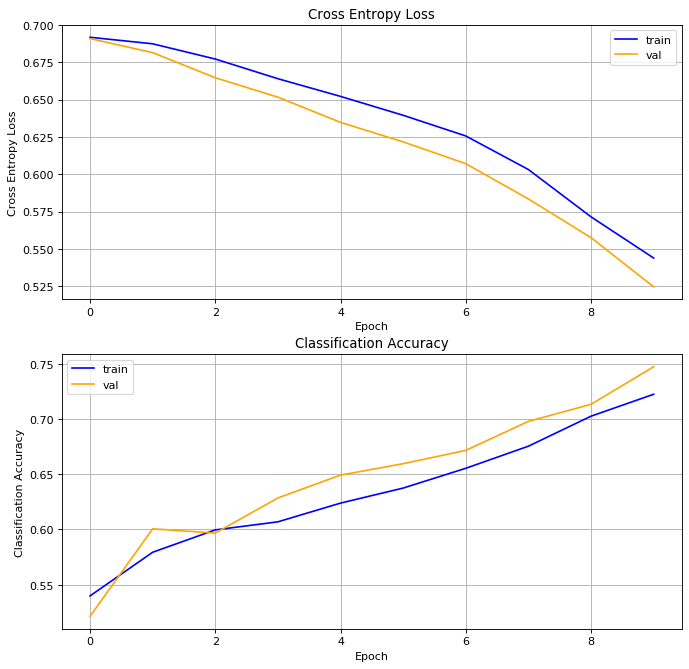

In [6]:
# Plot diagnostic learning curves
ml_utils.summarize_diagnostics(history)

## Identical runs

**tl;dr Results for identically-instantiated runs are very close (<0.2% difference in val accuracy between runs). Difference is due to usage of GPU.**

First, we perform a sanity check to ensure that multiple identical runs give the same result. Unfortunately, identical runs give slightly varying results, despite using TF_DETERMINISTIC_OPS as indicated in https://github.com/NVIDIA/tensorflow-determinism. I checked that initialization weights and the order of the training data are the same across runs. The problem seems to be related to the GPU, since when we use the CPU instead, identical runs give identical results.

In [31]:
initialization_weights = []

for i in range(5):    
    # Build and train model
    model = ml_utils.build_model()
    initialization_weights.append([w.value() for w in model.weights])
    history = model.fit(
        train,
        epochs=1,
        validation_data=validation
    )

582/582 [==============================] - 12s 21ms/step - loss: 0.6919 - accuracy: 0.5434 - val_loss: 0.6902 - val_accuracy: 0.5989


In [64]:
# Check that initialization weights are the same
from functools import reduce

weights_equal = True

#Iterate through iterations
for i in range(4):
    curr_weights = initialization_weights[i]
    next_weights = initialization_weights[i+1]

    # Iterate through layers
    for j in range(len(curr_weights)):
        weights_equal &= tf.math.reduce_all(tf.math.equal(curr_weights[j], next_weights[j]))
print("Weights equal = ", weights_equal)

Weights equal =  tf.Tensor(True, shape=(), dtype=bool)


In [48]:
# Try using CPU
for i in range(5):
    with tf.device('/cpu:0'):
        model = ml_utils.build_model()
        history = model.fit(
            train,
            epochs=1,
            validation_data=validation
        )

582/582 [==============================] - 160s 275ms/step - loss: 0.6919 - accuracy: 0.5438 - val_loss: 0.6902 - val_accuracy: 0.5985


## Batch Size

In [5]:
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
batch_histories = {}

for batch_size in batch_sizes:
    # Read training data
    batch_train, batch_validation, batch_test = ml_utils.load_batched_and_resized_dataset(
        dataset_name='cats_and_dogs',
        batch_size=batch_size,
        img_size=IMG_SIZE
    )

    # Build and train model
    model = ml_utils.build_model()
    history = model.fit(
        batch_train,
        epochs=10,
        validation_data=batch_validation
    )
    batch_histories[batch_size] = history.history

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 2326
Class: 0 :::: Count: 1120 :::: Percentage: 48.15133276010318
Class: 1 :::: Count: 1206 :::: Percentage: 51.84866723989682

Test Data Summary
No. of examples: 2326
Class: 0 :::: Count: 1160 :::: Percentage: 49.871023215821154
Class: 1 :::: Count: 1166 :::: Percentage: 50.128976784178846
Epoch 1/10
18610/18610 [==============================] - 209s 11ms/step - loss: 0.6608 - accuracy: 0.5945 - val_loss: 0.6080 - val_accuracy: 0.6986
Epoch 2/10
18610/18610 [==============================] - 151s 8ms/step - loss: 0.5586 - accuracy: 0.7123 - val_loss: 0.5174 - val_accuracy: 0.7575
Epoch 3/10
18610/18610 [==============================] - 148s 8ms/step - loss: 0.4907 - accuracy: 0.7590 - val_loss: 0.4846 - val_accuracy: 0.7700
Epoch 4/10
18610/18610 [==============================

No. of examples: 2326
Class: 0 :::: Count: 1160 :::: Percentage: 49.871023215821154
Class: 1 :::: Count: 1166 :::: Percentage: 50.128976784178846
Epoch 1/10
1164/1164 [==============================] - 30s 26ms/step - loss: 0.6903 - accuracy: 0.5485 - val_loss: 0.6898 - val_accuracy: 0.4931
Epoch 2/10
1164/1164 [==============================] - 16s 14ms/step - loss: 0.6753 - accuracy: 0.5900 - val_loss: 0.7274 - val_accuracy: 0.4854
Epoch 3/10
1164/1164 [==============================] - 16s 14ms/step - loss: 0.6526 - accuracy: 0.6191 - val_loss: 0.7378 - val_accuracy: 0.5034
Epoch 4/10
1164/1164 [==============================] - 16s 14ms/step - loss: 0.6251 - accuracy: 0.6529 - val_loss: 0.7064 - val_accuracy: 0.5370
Epoch 5/10
1164/1164 [==============================] - 16s 14ms/step - loss: 0.5806 - accuracy: 0.6955 - val_loss: 0.8565 - val_accuracy: 0.5150
Epoch 6/10
1164/1164 [==============================] - 16s 14ms/step - loss: 0.5405 - accuracy: 0.7289 - val_loss: 0.7764 -

Epoch 3/10
73/73 [==============================] - 7s 95ms/step - loss: 0.6922 - accuracy: 0.5661 - val_loss: 0.6921 - val_accuracy: 0.5808
Epoch 4/10
73/73 [==============================] - 7s 96ms/step - loss: 0.6919 - accuracy: 0.5821 - val_loss: 0.6918 - val_accuracy: 0.5899
Epoch 5/10
73/73 [==============================] - 7s 96ms/step - loss: 0.6915 - accuracy: 0.5918 - val_loss: 0.6914 - val_accuracy: 0.6015
Epoch 6/10
73/73 [==============================] - 7s 96ms/step - loss: 0.6910 - accuracy: 0.5964 - val_loss: 0.6909 - val_accuracy: 0.6118
Epoch 7/10
73/73 [==============================] - 7s 96ms/step - loss: 0.6906 - accuracy: 0.5993 - val_loss: 0.6904 - val_accuracy: 0.6126
Epoch 8/10
73/73 [==============================] - 7s 96ms/step - loss: 0.6901 - accuracy: 0.5995 - val_loss: 0.6898 - val_accuracy: 0.6139
Epoch 9/10
73/73 [==============================] - 7s 96ms/step - loss: 0.6895 - accuracy: 0.5989 - val_loss: 0.6892 - val_accuracy: 0.6096
Epoch 10/10
7

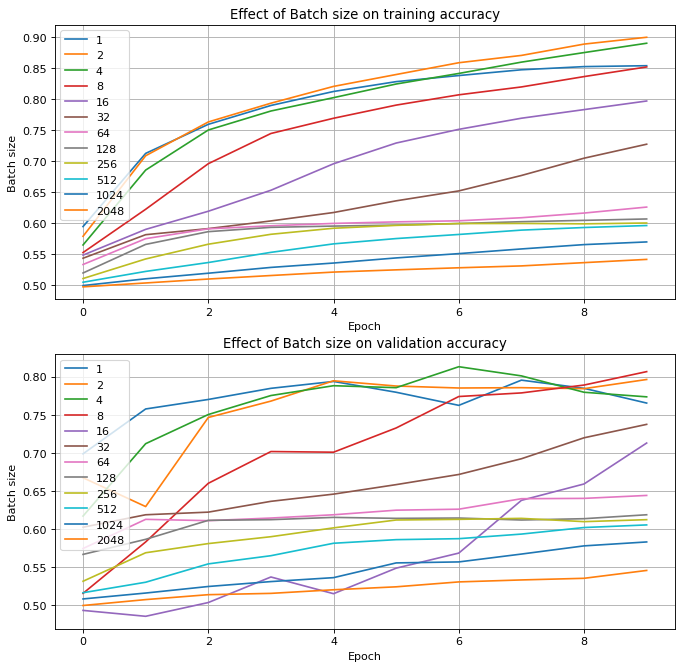

<Figure size 432x288 with 0 Axes>

In [8]:
ml_utils.plot_accuracies_by_param(batch_sizes, batch_histories, 'Batch size', 'batch_size_accuracies.png')

In [9]:
pickle.dump(batch_histories, open("pickled_objects/batch_histories.pickle", "wb" ))